<a href="https://colab.research.google.com/github/zszazi/pnemonia-detection/blob/master/pnemonia_prediction_on_anvil_with_mobile_notifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zszazi","key":"993dd55dbc522c9510115cad025c6073"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:22<00:00, 33.0MB/s]
100% 1.15G/1.15G [00:23<00:00, 53.7MB/s]


In [8]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

In [0]:
PATH = "../content/chest_xray/train/"


In [0]:
!cd ../content/chest_xray/train/

In [12]:

!ls

chest_xray		  chest_xray.zip  __MACOSX
chest-xray-pneumonia.zip  kaggle.json	  sample_data


In [13]:
from os import path
path.exists(PATH)

True

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks import csv_logger

In [0]:
data = ImageDataBunch.from_folder(PATH, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs = 64).normalize(imagenet_stats)

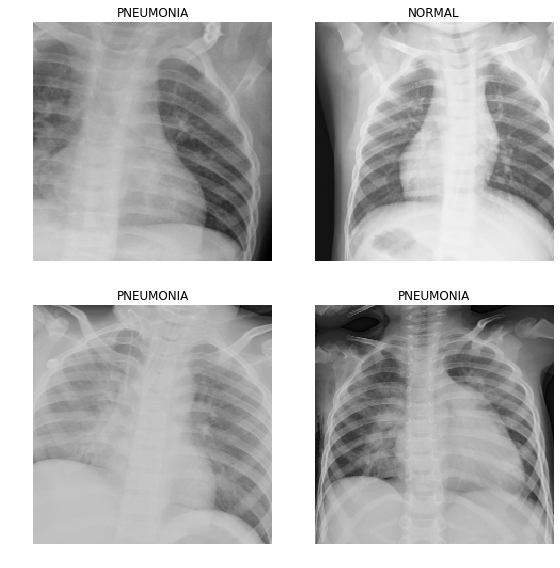

In [17]:
data.show_batch(rows = 2, fig = (5,5))

In [0]:
class NotificationCallback(Callback):
    """
        PyTorch callback for model training
    """
    def on_train_begin(self, metrics_names: StrList, **kwargs: Any) -> None:
        send_notification("Training has Begun ")

        
    def on_epoch_end(self,  epoch: int, smooth_loss: Tensor, last_metrics: MetricsList, **kwargs: Any) -> None:
        super().on_epoch_end(**kwargs)
        val_loss, accuracy = last_metrics[0], last_metrics[1]
        message = "Epoch: " +str(epoch+1) + "-> " +"Train loss: " +f"{smooth_loss.item():.4f}" + " , " +" Val loss: "+ f"{val_loss:.4f}" + " , " + " Accuracy: " +f"{accuracy:.4f}"
        send_notification(message)
        
    def on_train_end(self, metrics, **kwargs: Any) -> None:
        super().on_train_end(**kwargs)
        send_notification("Training finished ")

In [0]:
def send_notification(msg):
    """
        Send message to mobile using Pushover notifications.
        Calls Pushover API to do that.
        Pushover API docs: https://pushover.net/api
    """
    import requests
    from datetime import datetime

    url = "https://api.pushover.net/1/messages.json"
    data = {
        "user"  : "ubyy2b56hxjse9ne81iigm7w4hm363",
        "token" : "aaq548hx8mqespf6aiivmkomkhfqji",
        "sound" : "cashregister"
    }
    data["message"] = msg
    data['message'] = data['message'] + "\n" + str(datetime.now())

    r =  requests.post(url = url, data = data)

In [0]:
notif_cb = NotificationCallback()

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy,error_rate] , model_dir="/tmp/model/",callbacks = [notif_cb])

In [55]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.171261,0.130312,0.953979,0.046021,03:31
1,0.153351,0.095184,0.967402,0.032598,03:30
2,0.121993,0.077663,0.973154,0.026846,03:27
3,0.120675,0.076833,0.976031,0.023969,03:24
4,0.094030,0.091379,0.963567,0.036433,03:24


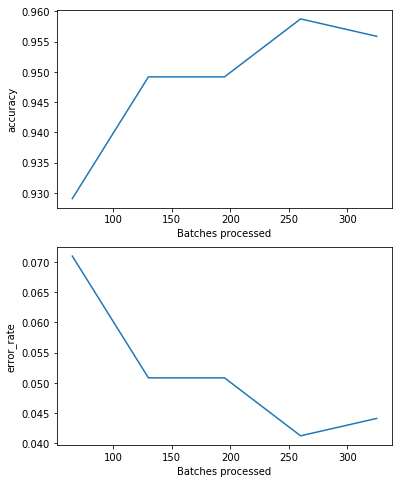

In [0]:
learn.recorder.plot_metrics()

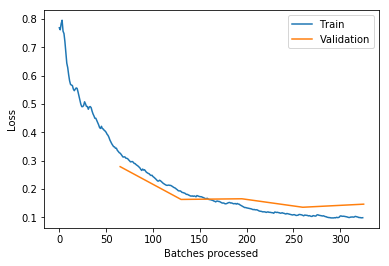

In [0]:
learn.recorder.plot_losses()

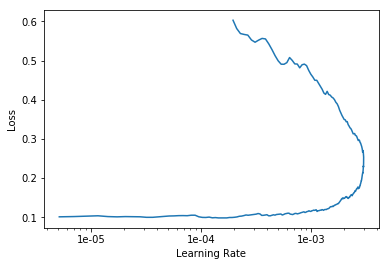

In [0]:
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.74E-04


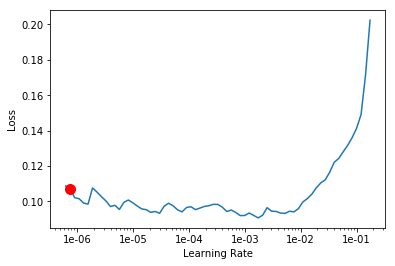

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

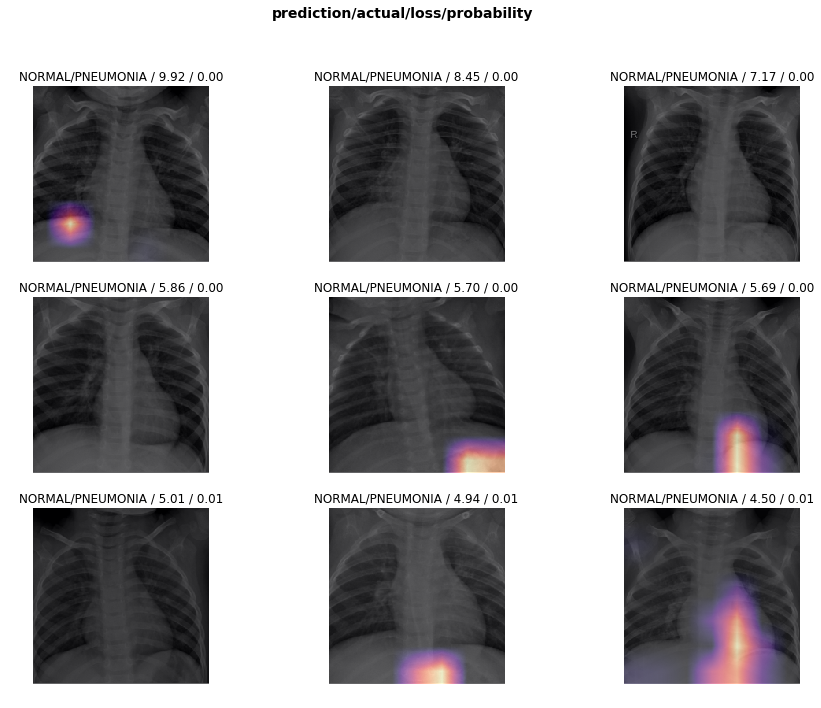

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

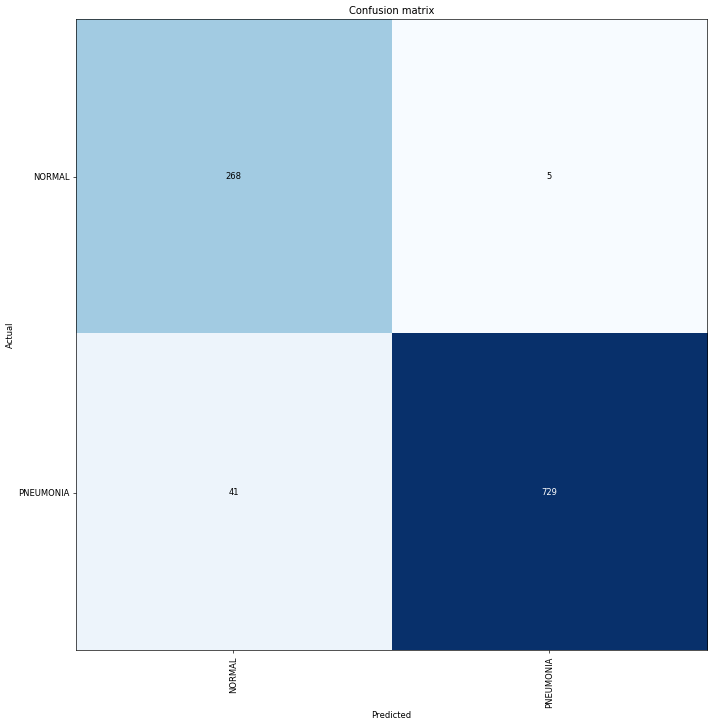

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.139196,0.088978,0.968360,0.031640,03:17


In [0]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 5.75E-07


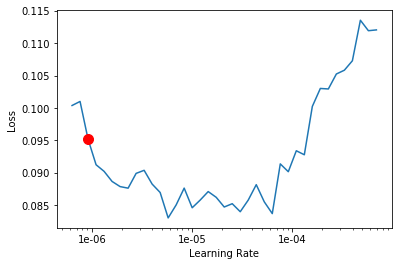

In [0]:

learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving no pnemonia NORMAL.jpeg to no pnemonia NORMAL.jpeg
Saving PNEUMONIA_person108_bacteria_507.jpeg to PNEUMONIA_person108_bacteria_507.jpeg
User uploaded file "no pnemonia NORMAL.jpeg" with length 408620 bytes
User uploaded file "PNEUMONIA_person108_bacteria_507.jpeg" with length 89320 bytes


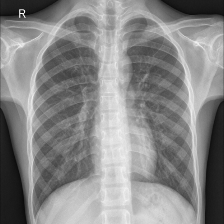

In [0]:
img = open_image('no pnemonia NORMAL.jpeg')
img.resize(224)


In [0]:
pred_Class , _ , _ = learn.predict(img)


In [0]:
pred_Class

Category NORMAL

In [56]:
!pip install ws4py

     |████████████████████████████████| 61kB 5.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


In [57]:
!pip install anvil-uplink --upgrade

  Stored in directory: /root/.cache/pip/wheels/38/42/f6/81c0b03b1e985677e53d3c01428adc236311539add0c161662
  Stored in directory: /root/.cache/pip/wheels/19/1f/0d/beff5822af761b66067b5e0b251a9c66af3ae15828ee9a8f15
Successfully built anvil-uplink ws4py
  Found existing installation: ws4py 0.5.1
    Uninstalling ws4py-0.5.1:
      Successfully uninstalled ws4py-0.5.1


In [58]:
import anvil.server

anvil.server.connect("G637KCUD7CSV33H7FRAYPTZC-OHZ4IRAQVE6NVONL")


Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil server output: You're using the Anvil Free plan. Upgrade at https://anvil.works/


In [0]:
import anvil.media

@anvil.server.callable
def classify_my_img(file):
  with anvil.media.TempFile(file) as filename:
    img = open_image(filename)
    
  #img = img.resize((224,224))
  
  pred_Class , _ , _ = learn.predict(img)
  return str(pred_Class)